In [2]:
from pathlib import Path

import pandas as pd 
import numpy as np
import geopandas as gpd 

from shapely import box
import pycountry

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colormaps as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs

from config.config import (WID_DATA_DIR, 
                           WID_DATA_PROCESSED,
                           fontsize_small,
                           fontsize_medium,
                           fontsize_large,
                           GRAPHICS_DIR,
                           EU27_ids
                           )

# Bar Graph

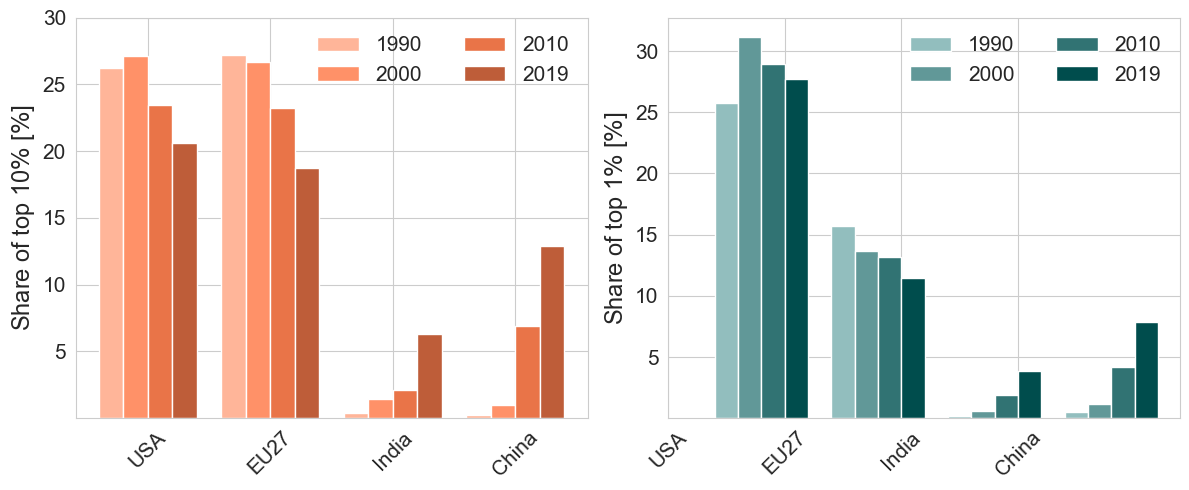

In [2]:
width = 0.2
multiplier = 0
position = np.arange(4)
region_id = 'WO'
groups = ['p90p100', 'p99p100']

colors_orange = sns.color_palette("blend:#FFB599,#FF7F50,#BE5D39", as_cmap=True)(np.linspace(0,1,4))
colors_teal = sns.color_palette("blend:#B6DADA,#004D4D", as_cmap=True)(np.linspace(0.2,1,4))
colors = [colors_orange, colors_teal]

y_labels = ['Share of top 10$\%$ [$\%$]', 'Share of top 1$\%$ [$\%$]']
sel_regions = ['USA', 'EU27', 'IND', 'CHN']
x_tick_labels = [['USA', 'EU27', 'India', 'China']]*2
y_ticks  = [[5,10,15,20,25,30]]*2
y_tick_labels = [[5,10,15,20,25,30]]*2
y_limits = [[0,30]]*2
x_ticks = [position + 1.5*width]*2

with sns.axes_style('whitegrid'):
    fig, axes  = plt.subplots(1,2, figsize = (12,5))
    
    for i, ax in enumerate(axes):
        group = groups[i]
        bar_graph_data =  pd.read_csv(WID_DATA_PROCESSED / 'wealthy_by_location' / f'WID_{region_id}_{group}_data_bar_graph.csv', sep = ';', index_col = 0)
        sel_bar_graph_data = bar_graph_data.loc[:, sel_regions]

        for i_year in range(4): 
            offset = width * multiplier
            ax.bar(position + offset, sel_bar_graph_data.iloc[i_year, :], width, color = colors[i][i_year], label = int(sel_bar_graph_data.index[i_year]))
            multiplier += 1
            
        ax.set_xticks(x_ticks[i],
                      x_tick_labels[i], 
                      rotation  = 45,
                      fontsize = fontsize_medium)
        ax.set_yticks(y_ticks[i],
                      y_tick_labels[i],
                      fontsize = fontsize_medium)
        ax.set_ylabel(y_labels[i], fontsize = fontsize_large)
        ax.legend(ncols = 2, frameon = False, fontsize = fontsize_medium)
    plt.tight_layout()
    # Path(GRAPHICS_DIR / "income_distribution").mkdir(parents=True, exist_ok=True)
    # plt.savefig(GRAPHICS_DIR / "income_distribution" / f"regional_bar-graph_timeseeries-shares.png", dpi = 600)
    plt.show()

# Map 

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


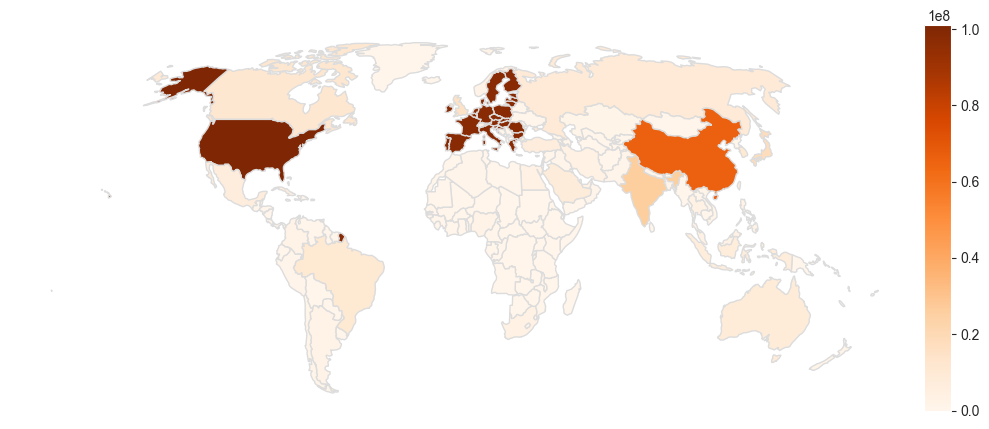

In [3]:
year      = 2019
group     = 'p90p100'
WID_region_id = 'WO'

country_shares_df = pd.read_csv(WID_DATA_PROCESSED / 'wealthy_by_location' / f'WID_data_{WID_region_id}_{group}_{year}.csv', sep = ';', index_col = 0) 

eu27_totals = country_shares_df.loc[EU27_ids, :].sum(axis = 0)
eu27_totals['fraction_of_population_in_group'] = eu27_totals['population_in_group']/eu27_totals['population_all']

# replace EU27 country shares with a single EU27 estimate 
country_shares_df = country_shares_df[~country_shares_df.index.isin(EU27_ids)]
country_shares_df.loc['EU27',:] = eu27_totals

isoa3 = dict(zip([f.alpha_2 for f in pycountry.countries], 
                [f.alpha_3 for f in pycountry.countries]))

isoa3['EU27'] = 'EU27'

country_shares_df.loc[:, 'iso_a3']   = [isoa3[f] for f in country_shares_df.index]
country_shares_df.loc[:, 'alpha_a2'] = country_shares_df.index
country_shares_df.index = country_shares_df.iso_a3

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.loc[world.name == 'France', 'iso_a3'] = 'FRA'
world.loc[world.name == 'Norway', 'iso_a3'] = 'NOR'
world.index = world.iso_a3

for iso in country_shares_df.index:
    
    if iso == 'EU27':
        for eu_alpha2 in EU27_ids:
            eu_alpha3 = isoa3[eu_alpha2]
            world.loc[eu_alpha3, 'adult_population_in_group'] = country_shares_df.loc[iso, 'adult_population_in_group']
            world.loc[eu_alpha3, 'percentage_of_adult_group'] = country_shares_df.loc[iso, 'adult_population_in_group']/country_shares_df.loc[:, 'adult_population_in_group'].sum()*100 
            world.loc[eu_alpha3, 'population_in_group'] = country_shares_df.loc[iso, 'population_in_group']
            world.loc[eu_alpha3, 'percentage_of_group'] = country_shares_df.loc[iso, 'population_in_group']/country_shares_df.loc[:, 'population_in_group'].sum()*100
    else: 
        try: 
            world.loc[iso, 'adult_population_in_group'] = country_shares_df.loc[iso, 'adult_population_in_group']
            world.loc[iso, 'percentage_of_adult_group'] = country_shares_df.loc[iso, 'adult_population_in_group']/country_shares_df.loc[:, 'adult_population_in_group'].sum()*100
            world.loc[iso, 'population_in_group'] = country_shares_df.loc[iso, 'population_in_group']
            world.loc[iso, 'percentage_of_group'] = country_shares_df.loc[iso, 'population_in_group']/country_shares_df.loc[:, 'population_in_group'].sum()*100
        except:
            pass

robinson = ccrs.Robinson().proj4_init

with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize = (10,6))
    divider = make_axes_locatable(ax)
    cax     = divider.append_axes('right', size='3%', pad=0.04)
    cmap2 = cm['Oranges'].copy()
    world.to_crs(robinson).plot(column='adult_population_in_group', ax=ax, legend=True, cmap = 'Oranges', vmin = -1, cax = cax, edgecolor = 'gainsboro')
    ax.set_axis_off()   
    plt.tight_layout()
    plt.show()

## Income clasification

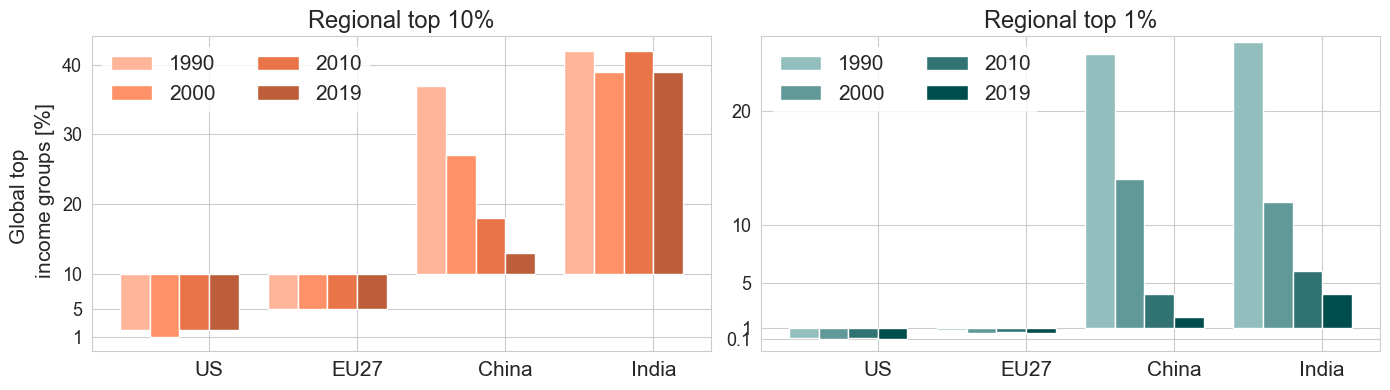

In [3]:
width = 0.2
position = np.arange(4)
groups = ['p90p100', 'p99p100']
titles = ['Regional top 10%', 'Regional top 1%']
deduction = [10,1]
colors_orange = sns.color_palette("blend:#FFB599,#FF7F50,#BE5D39", as_cmap=True)(np.linspace(0,1,4))
colors_teal = sns.color_palette("blend:#B6DADA,#004D4D", as_cmap=True)(np.linspace(0.2,1,4))

colors = [colors_orange, colors_teal]

with sns.axes_style('whitegrid'):
    fig, axes = plt.subplots(1,2, figsize = (14,4))
    for i_group, group in enumerate(['p90p100', 'p99p100']):
        # data
        country_threshold_df = pd.read_csv(WID_DATA_PROCESSED / 'income_classification' / f'WID_classified_income_{group}.csv', sep = ';', index_col = 0)
        country_threshold_df['EU27'] = country_threshold_df.loc[:, EU27_ids].median(axis = 1)
        # graph
        ax = axes[i_group]
        multiplier  = 0
        for i_year, year in enumerate([1990,2000,2010,2019]): 
            offset = width * multiplier
            for i_region, region in enumerate(['US', 'EU27', 'CN', 'IN']):
                if i_region == 0: 
                    ax.bar(position[i_region] + offset, 
                        country_threshold_df.loc[year, region]-deduction[i_group], 
                        width = width, color = colors[i_group][i_year], label = year)
                else: 
                    ax.bar(position[i_region] + offset, 
                        country_threshold_df.loc[year, region]-deduction[i_group], 
                        width = width, color = colors[i_group][i_year])
            multiplier += 1   
        if i_group == 0:
            ax.set_yticks([-9, -5, 0, 10, 20, 30], 
                          [1,5,10,20,30,40],
                          fontsize = fontsize_small)
            ax.set_ylabel('Global top \n income groups [$\%$]', fontsize = fontsize_medium)
        if i_group == 1: 
            ax.set_yticks([-0.9, 0, 4, 9, 19], 
                          [0.1, 1, 5, 10, 20],
                          fontsize = fontsize_small) 
            ax.set_ylim(-2,25.5)
        ax.set_xticks([0.5,1.5,2.5,3.5], 
                      ['US', 'EU27', 'China', 'India'],
                      fontsize = fontsize_medium)
        ax.set_title(titles[i_group], fontsize = fontsize_large)
        ax.legend(ncol = 2, frameon = True, edgecolor = 'none', facecolor = (1,1,1,.7), fontsize = fontsize_medium, loc = 'upper left')
    fig.tight_layout()
    plt.show()

    

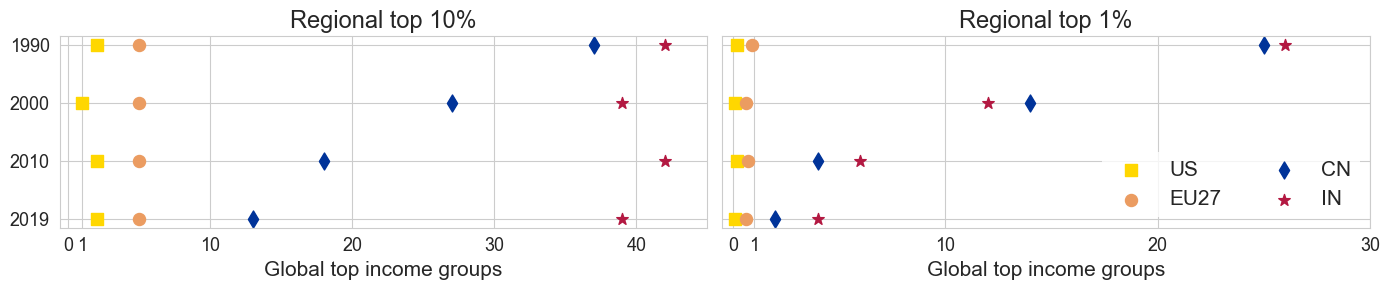

In [75]:
symbols = ['s', 'o', 'd', '*']
colors = ['gold', '#EB9C61', '#003399', '#B31942']
# colors = ['orange', 'teal']


with sns.axes_style('whitegrid'):
    fig, axes = plt.subplots(1,2, figsize = (14,3))
    for i_group, group in enumerate(['p90p100', 'p99p100']):
        ax = axes[i_group]
        country_threshold_df = pd.read_csv(WID_DATA_PROCESSED / 'income_classification' / f'WID_classified_income_{group}.csv', sep = ';', index_col = 0)
        country_threshold_df['EU27'] = country_threshold_df.loc[:, EU27_ids].median(axis = 1)
        for i_year, year in enumerate([1990,2000,2010,2019]): 
                for i_region, region in enumerate(['US', 'EU27', 'CN', 'IN']):
                    if i_year == 0:
                        ax.scatter(country_threshold_df.loc[year, region],
                                    3.5-i_year,
                                    marker = symbols[i_region], 
                                    color = colors[i_region],
                                    s = 75, 
                                    label = region)
                    else: 
                        ax.scatter(country_threshold_df.loc[year, region],
                                    3.5-i_year,
                                    marker = symbols[i_region], 
                                    color = colors[i_region],
                                    s = 75)                        
        if i_group == 0:
            ax.set_xlim(-0.6,45)
            ax.set_xticks([0, 1,10,20,30,40],
                            [0, 1,10,20,30,40], 
                            fontsize = fontsize_small)
            ax.set_yticks([0.5,1.5,2.5,3.5], 
                        [2019, 2010, 2000, 1990],
                        fontsize = fontsize_small)
        if i_group == 1:
            ax.set_xlim(-0.5,30)
            ax.set_xticks([0, 1,10,20,30],
                            [0, 1,10,20,30],
                            fontsize = fontsize_small)     
            ax.legend(loc = 'lower right', 
                      fontsize = fontsize_medium,
                      frameon = True, 
                      edgecolor = 'none', 
                      facecolor = (1,1,1,0.7),
                      ncols = 2)
            ax.set_yticks([0.5,1.5,2.5,3.5], 
                            [])
        ax.set_title(titles[i_group], 
                    fontsize = fontsize_large)
        ax.set_xlabel('Global top income groups', 
                      fontsize = fontsize_medium)
                    #     ax.set_ylim(0.1,0.3)
    fig.tight_layout()
    plt.show()